In [18]:
import random
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt


In [19]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Ensure the image is the correct size
    image = image.convert('RGB')  # Convert to RGB
    image = np.array(image).astype(np.float32)  # Cast to float32
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image


In [40]:
def load_dataset(data_dir, generated_chars_dir, images_per_glyph=5):
    handwritten_image_files = [os.path.join(root, file)
                               for root, _, files in os.walk(data_dir)
                               for file in files if file.endswith(('.jpg', '.png', '.jpeg'))]
    
    generated_image_files = [os.path.join(generated_chars_dir, file)
                             for file in os.listdir(generated_chars_dir)
                             if file.endswith('.png') and not file.startswith('.')]

    glyphs = set(os.path.basename(os.path.dirname(file)) for file in handwritten_image_files)
    selected_handwritten_files = []
    selected_generated_files = []

    for glyph in glyphs:
        glyph_handwritten_files = [file for file in handwritten_image_files if os.path.basename(os.path.dirname(file)) == glyph]
        glyph_generated_files = [file for file in generated_image_files if os.path.basename(file).split('.')[0] == glyph]

        if glyph_generated_files:
            selected_handwritten_files.extend(random.sample(glyph_handwritten_files, min(len(glyph_handwritten_files), images_per_glyph)))
            selected_generated_files.extend(glyph_generated_files * min(len(glyph_handwritten_files), images_per_glyph))

    handwritten_images = [load_and_preprocess_image(file) for file in tqdm(selected_handwritten_files, desc="Loading handwritten images")]
    generated_images = [load_and_preprocess_image(file) for file in tqdm(selected_generated_files, desc="Loading generated images")]

    return np.array(generated_images), np.array(handwritten_images)

train_data_path = '/chinese-handwriting/CASIA-HWDB_Train/Train'
test_data_path = '/chinese-handwriting/CASIA-HWDB_Test/Test'
generated_chars_path = '/Generated_Characters'

train_generated_images, train_handwritten_images = load_dataset(train_data_path, generated_chars_path, images_per_glyph=5)
test_generated_images, test_handwritten_images = load_dataset(test_data_path, generated_chars_path, images_per_glyph=5)

# Converting to tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_generated_images, train_handwritten_images))
test_dataset = tf.data.Dataset.from_tensor_slices((test_generated_images, test_handwritten_images))

# Shuffling and batching
BUFFER_SIZE = 1000
BATCH_SIZE = 1

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Loading generated images: 100%|██████████| 890/890 [00:00<00:00, 1048.56it/s]


In [41]:
val_dataset=test_dataset

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Concatenate, ReLU
from tensorflow.keras.models import Model
import os
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt

In [25]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [26]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    down4 = downsample(512, 4)(down3)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer, padding='same')(down4)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss


In [28]:
class Pix2Pix(tf.keras.Model):
    def __init__(self, generator, discriminator, generator_optimizer, discriminator_optimizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def compile(self, generator_loss, discriminator_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, data):
        input_image, target = data
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)
            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            gen_loss = self.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}
    
    def call(self, inputs):
        return self.generator(inputs)


In [29]:
# Instantiate the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Instantiate the optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Instantiate the custom model
pix2pix_model = Pix2Pix(generator, discriminator, generator_optimizer, discriminator_optimizer)

# Compile the model
pix2pix_model.compile(
    generator_loss=generator_loss,
    discriminator_loss=discriminator_loss,
    loss='binary_crossentropy'  # Dummy loss
)


In [ ]:
EPOCHS=100
pix2pix_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6822 - gen_loss: 18.4959 - loss: 0.0000e+00 - val_loss: 3.4656
Epoch 2/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6662 - gen_loss: 18.4689 - loss: 0.0000e+00 - val_loss: 3.4985
Epoch 3/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6652 - gen_loss: 18.4438 - loss: 0.0000e+00 - val_loss: 3.4424
Epoch 4/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6576 - gen_loss: 18.4280 - loss: 0.0000e+00 - val_loss: 3.5176
Epoch 5/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6724 - gen_loss: 18.4595 - loss: 0.0000e+00 - val_loss: 3.5012
Epoch 6/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6630 - gen_loss: 18.4518 - loss: 0.0000e+00 - val_loss: 3.4719
Epoch 7/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0.6701 - gen_loss: 18.4349 - loss: 0.0000e+00 - val_loss: 3.5137
Epoch 8/100
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - disc_loss: 0

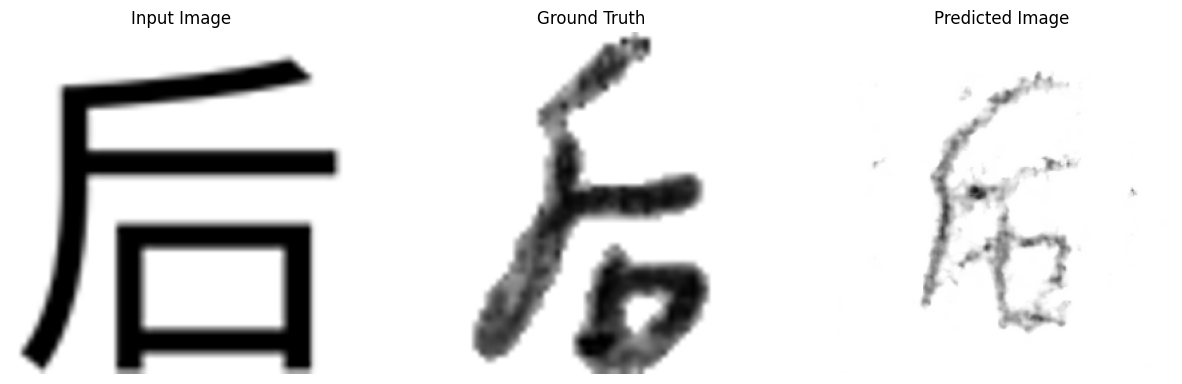

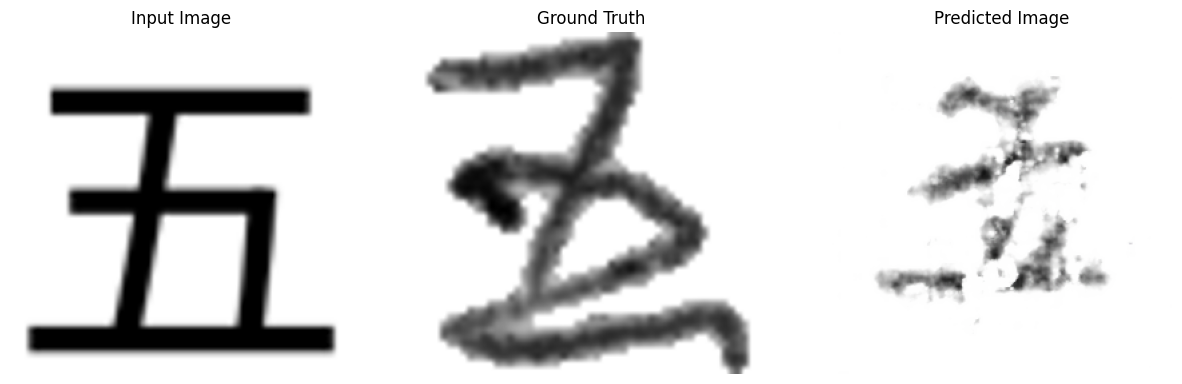

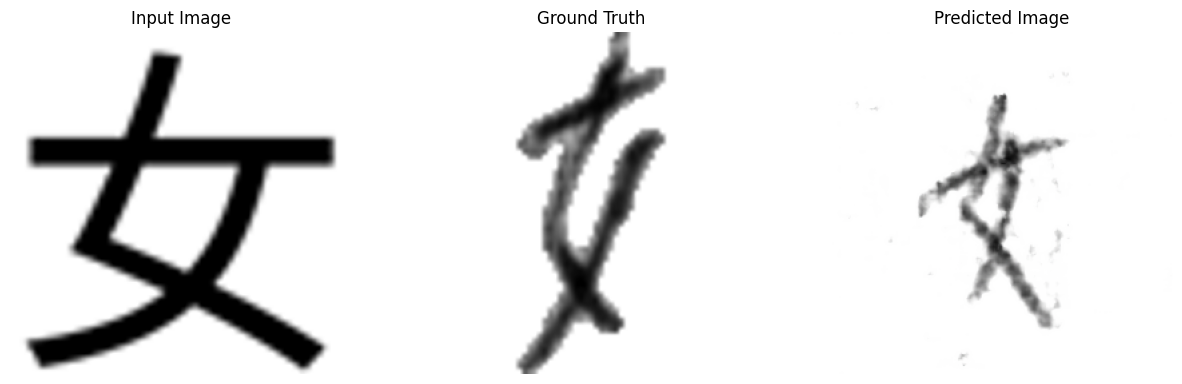

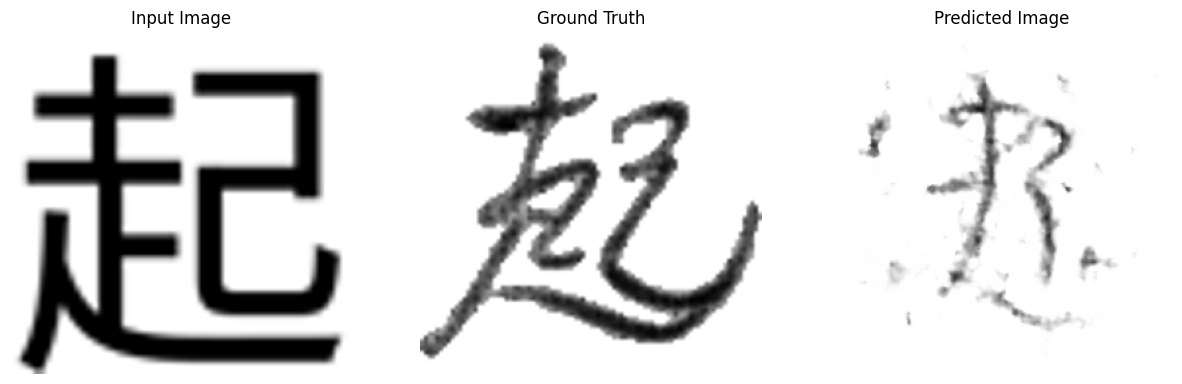

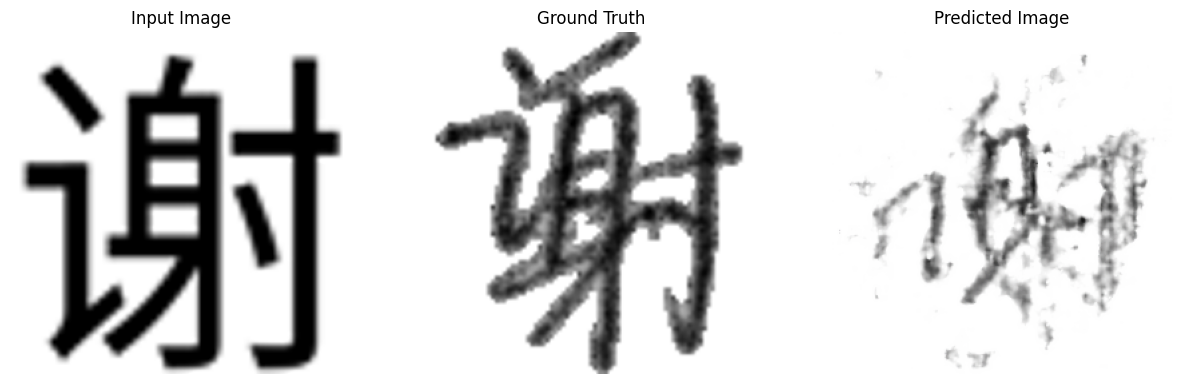

2024-06-27 09:40:23.330346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [55]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, test_input, target, epoch):
    prediction = model(test_input, training=False)

    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values back to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.savefig(f'output_epoch_{epoch+1}.png')
    plt.show()

# Generate and save images from the validation dataset
for example_input, example_target in val_dataset.take(5):
    generate_and_save_images(pix2pix_model.generator, example_input, example_target, epoch=50)


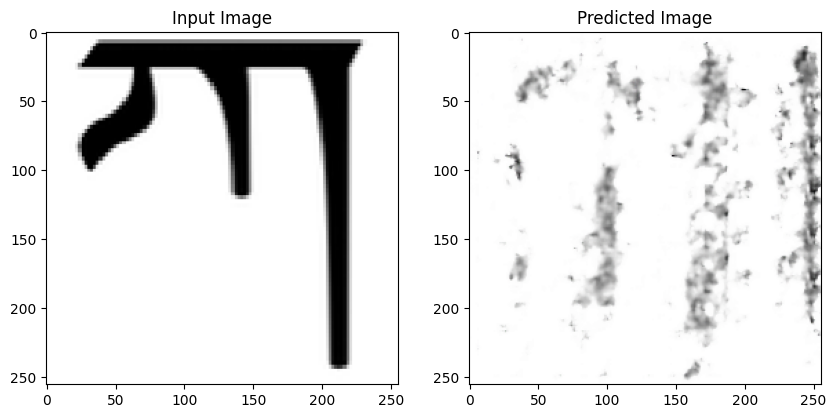

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)
    return img

# Load the image
img_path = '/1.png'
input_image = load_and_preprocess_image(img_path)

# Generate the prediction
prediction = generator(input_image, training=False)

# Convert the prediction back to image format
prediction_image = (prediction[0] + 1) * 127.5
prediction_image = prediction_image.numpy().astype(np.uint8)

# Display the original and predicted images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(image.array_to_img(input_image[0]))

plt.subplot(1, 2, 2)
plt.title('Predicted Image')
plt.imshow(image.array_to_img(prediction_image))

plt.show()
